Это домашнее задание направлено на знакомство с алгоритмом к-ближайших соседей. По правилам  можно только KNN (sklearn.neighbors.KNeighborsClassifier), метрика - F1.

## 1. Загрузка библиотек

In [30]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pylab
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,5)

import warnings
warnings.filterwarnings('ignore')

## 2. Загрузка тренировочной и тестовой выборки

In [2]:
df_train = pd.read_csv('hw3_train.csv')
df_test = pd.read_csv('hw3_test_data.csv')

In [3]:
df_train['sample'] = 'train'
df_test['sample'] = 'test'
df = pd.concat([df_train, df_test], axis=0, ignore_index=True, sort=False)

## 3. Анализ и подготовка данных

Подробный анализ данных проведен в ноутбуке с аналогичным заданием про изучение алгоритма дерева принятия решений (в репозитории DataGym/03_tree_and_knn/hw_03_tree.ipynb). Подготовка данных для модели KNN аналогична, за исключением того, что в конце все данные необходимо пронормировать. В библиотеке sklearn для этого есть модуль StandartScale(), но тут мы это сделаем вручную.


Дополнительно посмотрим на распределение значений 'household_income':

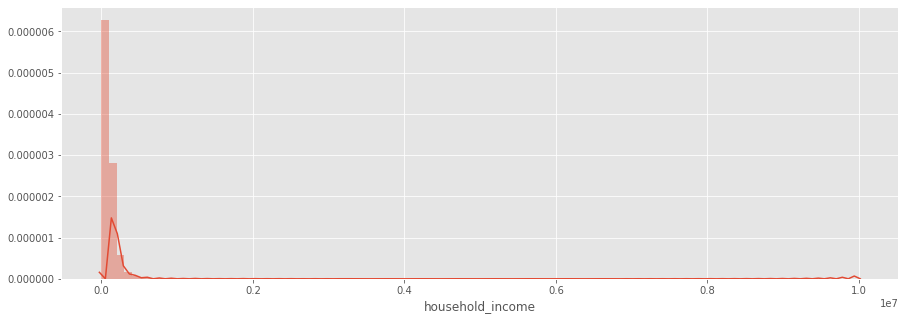

In [31]:
sns.distplot(df['household_income'], bins=100)

Распределение значений данной переменной имеет "очень тяжелый хвост", попробуем прологарифмировать данные:

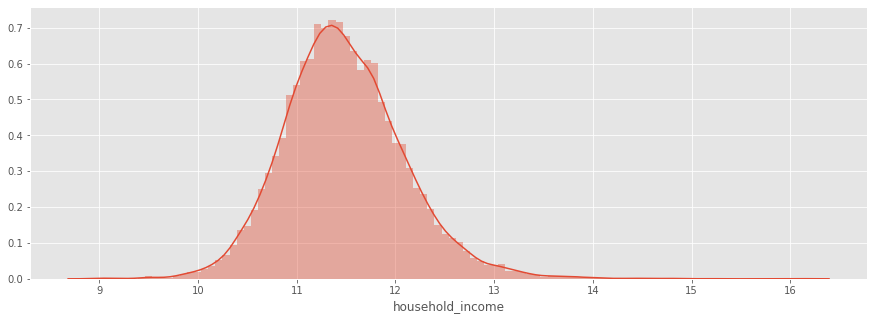

In [32]:
sns.distplot(df['household_income'].map(lambda x: np.log(x)), bins=100)

Так выглядит аккуратнее. Взглянем ещё на значение 'seniority_month':

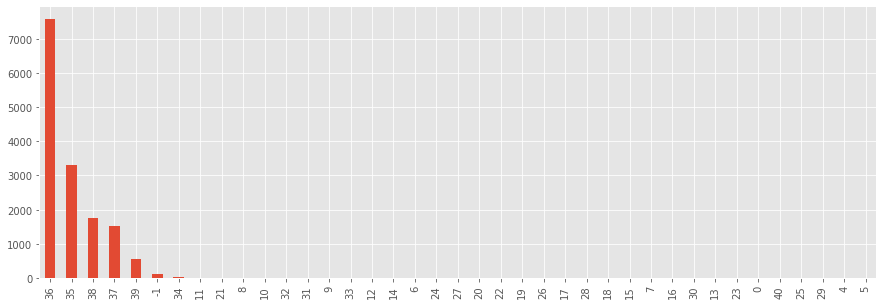

In [33]:
df['seniority_month'].value_counts().plot(kind='bar', label='seniority_month')

Большинство значений можно разделить по приципу - равно 36, не равно 36, но больше 35, и остальные. Учтём это при подготовке данных

In [7]:
def prepare_data(df_input):
    df_output = df_input.copy()
    
    df_output = df_output.drop(['customer_id', 'adress_type', 'customer_residence_code',\
                                'customer_type', 'use_savings', 'use_guarantees',\
                                'use_derivada_account'], axis = 1)
    
    for i in ['household_income', 'age', 'seniority_month']:
        df_output[i] = df_output[i].map(lambda x: int(df_output[i].median()) if x == -1 else x)
    
    for i in ['activity_index', 'is_new_customer']:
        df_output[i] = df_output[i].map(lambda x: random.randint(0, 1) if x == -1 else x)
    
    df_output['gender'] = df_output['gender'].map(lambda x: random.choice([0, 2]) if x == 1 else x)
    df_output['use_pensions'] = df_output['use_pensions'].map(lambda x: 1 if x == -1 else x)
    df_output['household_income'] = df_output['household_income'].map(lambda x: np.log(x))
    
    def month(x):
        if x == 36:
            return 2
        elif x>=35 and x !=36:
            return 1
        else:
            return 0
        
    df_output['seniority_month'] = df_output['seniority_month'].map(month)
    
    #нормализация своими руками
    not_object_columns = df_output[df_output.select_dtypes(exclude=['object']).columns].columns
    for i in not_object_columns:
        if df_output[i].max()>2:
            mu = df_output[i].mean()
            sigma = df_output[i].std()
            df_output[i] = df_output[i].map(lambda x: (x-mu)/sigma)
   
    return df_output

In [8]:
df_new = prepare_data(df)

In [9]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,15000.0,9.614667e-01,0.999291,0.000000,0.000000,0.000000,2.000000,2.000000
age,15000.0,-3.562354e-15,1.000000,-2.104564,-0.628118,-0.464069,0.356179,5.605764
is_new_customer,15000.0,3.933333e-03,0.062595,0.000000,0.000000,0.000000,0.000000,1.000000
seniority_month,15000.0,1.500600e+00,0.523467,0.000000,1.000000,2.000000,2.000000,2.000000
customer_relation_type,15000.0,-8.063461e-15,1.000000,-1.091175,-1.091175,0.859209,0.859209,4.759978
residence_same_as_bank,15000.0,1.991467e+00,0.094839,0.000000,2.000000,2.000000,2.000000,2.000000
country_same_as_bank,15000.0,8.600000e-02,0.395745,0.000000,0.000000,0.000000,0.000000,2.000000
join_channel,15000.0,2.647009e-15,1.000000,-3.050528,-0.849252,0.618265,0.618265,2.085782
activity_index,15000.0,4.996667e-01,0.500017,0.000000,0.000000,0.000000,1.000000,1.000000
household_income,15000.0,-1.369597e-12,1.000000,-4.435385,-0.510276,-0.273686,0.542178,8.324847


## 4. Подготовка тренировочной выборки

In [10]:
df_train_new = df_new[df_new['sample']=='train'].drop('sample', axis=1)
df_test_new = df_new[df_new['sample']=='test'].drop(['sample', 'use_direct_debit'] , axis=1)
target = df_train_new['use_direct_debit']
df_train_new = df_train_new.drop('use_direct_debit', axis=1)
df_train_new.shape, df_test_new.shape

((7500, 21), (7500, 21))

Отделим 20% данных для "теста" итоговой модели:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_train_new, target, test_size=0.2, random_state=9)

По аналогии с решением этой задачи методом дерева будем использовать 'стратифицированные холды' (StratifiedKFold).


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=36)
scoring = 'f1'

## 5. Построение модели

Рассмотрим основные гиперпараметры KNeighborsClassifier:
    1. n_neighbors - количество "ближайших" соседей;
    2. weights - функция, по которой определеяется расстояние до соседа (может быть 'uniform' - учитывается 
    только расстояние, 'distance' - учитывается "взвешенное" растояние, то есть вес "соседа" обратно 
    пропорционален расстоянию до тестового примера, также можно задать функцию самостоятельно);
    3. algorithm - алгоритм, используемый для вычисления ближайших соседей, может принимать значения 'auto'
    (автоматический выбор алгоритма),  'ball_tree',  'kd_tree', (расстояние между примерами хранятся в дереве, 
    что ускоряет нахождение ближайших соседей) 'brute' (соседи для каждого тестового примера считаются 
    перебором обучающей выборки);
    4. leaf_size - размер листа (количество примеров в листе) при использовании алгоритмов 'ball_tree',  
    'kd_tree';
    5. metric - способ определения расстояния до соседа. Может принимать значения 'minkowski', 'manhattan',
    'euclidean', 'chebyshev' и т.д. (связанные гиперпараметры - metric_params, p);
    6. n_jobs - количество используемых ядер процессора для поиска ближайших соседей. Эту модель можно
    распаралелить.
    
   *** описание гиперпараметров частично взять из статьи https://habr.com/ru/company/ods/blog/322534/#metod-blizhayshih-sosedey

Нам нужна отправная точка - построим модель "из коробки" и посмотрим на значение нашей метрики.

In [13]:
knn_blackbox_model = KNeighborsClassifier()
z = cross_val_score(knn_blackbox_model, X_train, y_train, scoring=scoring, cv=cv)
print(f'f1 - {z.mean():.5f}')

f1 - 0.43480


Отлично, теперь нужно улучшить нашу модель. Так как подбор гиперпараметров будем проводить вручную - это может занять достаточно много времени, начнем с поиска оптимального числа соседей: построим график зависимости нашей метрики от количества соседей. Для удобства выберем параметры: weights = 'uniform', algorithm = 'brute', metric = 'euclidean'

In [14]:
neighbors = []
score = []
s_max = 0
for n_neighbors in tqdm(range(1, 50)):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights = 'distance',\
                               algorithm = 'brute', metric = 'euclidean', n_jobs = 3)
    z = cross_val_score(knn, X_train, y_train, scoring=scoring, cv=cv)
    neighbors.append(n_neighbors)
    score.append(z.mean())
    if z.mean() > s_max:
        s_max = z.mean()

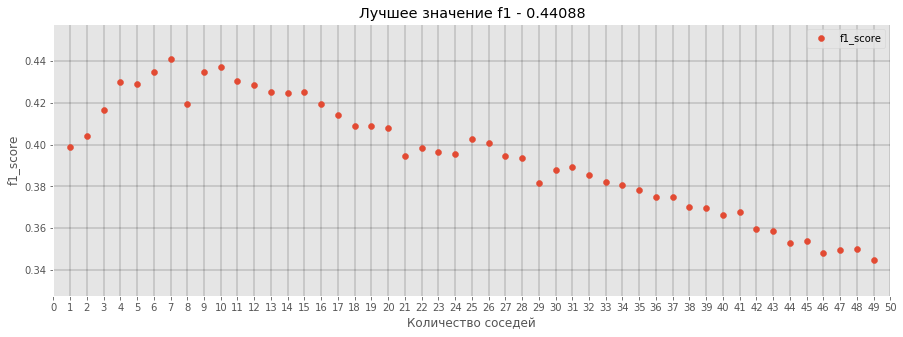

In [34]:
fig, ax = plt.subplots()
plt.scatter(neighbors, score, label='f1_score', marker='o')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.grid(which='major', color = 'k', linewidth = 0.25)

plt.xlabel('Количество соседей')
plt.ylabel('f1_score')
plt.title(f'Лучшее значение f1 - {s_max:.5f}')
pylab.xlim (0, 50)
plt.legend()

Максимальное значение при количестве соседей - 7. Для дальнейшего подбора гиперпараметров будем использовать интервал n_neighbors in [5, 7, 9].

Посмотрим, как влияет значение metric: 

In [16]:
k = 0
best_parametrs = []
for n_neighbors in tqdm([5, 7, 9]):
    for metric in ['minkowski', 'manhattan','euclidean', 'chebyshev']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = metric, weights = 'distance',\
                               algorithm = 'brute',  n_jobs = 3)
        z = cross_val_score(knn, X_train, y_train, scoring=scoring, cv=cv)
        if z.mean() > k:
            k = z.mean()
            best_parametrs = [z.mean(), n_neighbors,  metric]
print(f'f1 - {best_parametrs[0]:.5f},\
      Количество соседей - {best_parametrs[1]}, \
      Расстояние - {best_parametrs[2]}')
    


f1 - 0.45102,      Количество соседей - 9,       Расстояние - manhattan


Лучшее значение метрики показало при количества соседей - 7. Расстояние будем считать методом manhattan. Посмотрим на изменение метрики при взвешенном и нет расстоянии.

In [17]:
k = 0
best_parametrs = []
for n_neighbors in tqdm([5, 7, 9]):
    for weights in ['uniform','distance']:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = 'manhattan', weights = weights,\
                               algorithm = 'brute',  n_jobs = 3)
        z = cross_val_score(knn, X_train, y_train, scoring=scoring, cv=cv)
        if z.mean() > k:
            k = z.mean()
            best_parametrs = [z.mean(), n_neighbors,  weights]
print(f'f1 - {best_parametrs[0]:.5f}, \
      Количество соседей - {best_parametrs[1]},\
      Тип расстояния - {best_parametrs[2]}')


f1 - 0.46185,       Количество соседей - 7,      Тип расстояния - uniform


Значение метрики немного увеличилось. Осталось подобрать алгоритм, используемый для вычисления ближайших соседей.

In [18]:
k = 0
best_parametrs = []
for n_neighbors in tqdm([5, 7, 9]):
    for algorithm in ['auto', 'ball_tree',  'kd_tree', 'brute']:
        if algorithm in ['ball_tree', 'kd_tree']:
            for leaf in range(1, 52, 2):
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = 'manhattan',\
                                           weights = 'uniform', algorithm = algorithm, \
                                           leaf_size = leaf, n_jobs = 3)
                z = cross_val_score(knn, X_train, y_train, scoring=scoring, cv=cv)
                if z.mean() > k:
                    k = z.mean()
                    best_parametrs = [z.mean(), n_neighbors,  algorithm, leaf]
        else:
            knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric = 'manhattan',\
                                       weights = 'uniform', algorithm = algorithm, \
                                       n_jobs = 3)
            z = cross_val_score(knn, X_train, y_train, scoring=scoring, cv=cv)
            if z.mean() > k:
                k = z.mean()
                best_parametrs = [z.mean(), n_neighbors,  algorithm]
                    
if len(best_parametrs) == 4:
    print(f'f1 - {best_parametrs[0]:.5f},\
    Количество соседей - {best_parametrs[1]},\
    Алгоритм - {best_parametrs[2]},\
    Количество листов - {best_parametrs[3]}')
else:
    print(f'f1 - {best_parametrs[0]:.5f},\
    Количество соседей - {best_parametrs[1]},\
    Алгоритм - {best_parametrs[2]}')


f1 - 0.46332,    Количество соседей - 7,    Алгоритм - ball_tree,    Количество листов - 3


Результат стал ещё немного лучше. Гиперпараметры для модели с текущими входными данными подобраны, осталось проверить модель на отложенной выборке:

In [19]:
final_knn = KNeighborsClassifier(n_neighbors=7, metric = 'manhattan', weights = 'uniform', \
                                 algorithm = 'ball_tree', leaf_size =3, n_jobs = 3)


In [29]:
final_knn.fit(X_train, y_train)
prediction = final_knn.predict(X_test)
print(f'f1 - {f1_score(y_test, prediction):.5f}')

f1 - 0.49673


Значение метрики выше, чем при использовании модели из коробки. Оно, конечно, не идиально, но для решения такого плана задач будет лучше использовать ансамбливые медоты, которые будут рассмотрены позже